In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from dmba import classificationSummary
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")
%matplotlib inline

no display found. Using non-interactive Agg backend


In [2]:
df_p = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Patient List.xlsx')

p_a = pd.read_csv('/Users/jialinshang/Desktop/field project/raw/Appointment List.csv', 
                           names=['Office ID', 'Appointment ID', 'Patient ID', 'Provider Short ID', 'Appointment Date', 
                                  'Appointment Length','Appointment Status','New Patient','Missed Appointment',
                                  'DateTime Marked As Missed','Marked As Missed By','Cancelled Appointment',
                                  'DateTime Marked As Cancelled','Marked As Cancelled By','Appointment Posted'],
                           parse_dates=['Appointment Date','DateTime Marked As Missed', 'DateTime Marked As Cancelled'])

df_provider = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Provider List.xlsx')

df_office = pd.read_excel('/Users/jialinshang/Desktop/field project/raw data/Office List.xlsx')

df_recall = pd.read_csv('/Users/jialinshang/Desktop/field project/raw/Recall List.csv' , header=None)
df_recall.columns = ['Patient ID', 'Office ID', 'Procedure Code', 'Recall Date', 'Recall Reason']


In [10]:
p_a1 = p_a[p_a['Patient ID']!=0]
p_a1 = p_a1[(p_a1['Cancelled Appointment'] == 'N') & (p_a1['Missed Appointment'] == 'N')]
p_a1 = p_a1.sort_values(by='Appointment Date')

In [12]:
IDtime = p_a1.groupby('Patient ID')[('Appointment Date')].apply(list).to_dict()

In [14]:
def getdate(dictkey, dictvalue):
    long = len(dictvalue)
    new = []
    for i in range (0,long):
        if i == long-1:
            pass
        else: 
            diff = str(dictvalue[i+1] - dictvalue[i])   
            diff = int(diff.split(' ')[0])
            new.append(diff)
    total = sum(k<540 for k in new)
    if total == 0:
        return True #is a new patient
    else:
        return False #not a new patient

In [15]:
newID = []
nonnewID = []
for keys, values in IDtime.items():
    if getdate(keys, values) is True:
        newID.append(keys)
    else:
        nonnewID.append(keys)

In [16]:
new_p = pd.DataFrame(newID,columns=['Patient ID'])
new_p['newpatient'] = 'Y'
nonnew_p = pd.DataFrame(nonnewID,columns=['Patient ID'])
nonnew_p['newpatient'] = 'N'
havenew = pd.concat([new_p,nonnew_p])

In [21]:
havenew

,Patient ID,newpatient
0,1000039,Y
1,1000774,Y
2,1000783,Y
3,1001438,Y
4,1002587,Y
...,...,...
308114,186013719,N
308115,186013731,N
308116,186013742,N
308117,186013750,N


In [25]:
newpatient = pd.merge(havenew, df_p, on = 'Patient ID', how = 'left')
newpatient = newpatient.rename(columns={"Patient Home Office ID": "Office ID"})

In [28]:
newpatient = pd.merge(newpatient, df_office, on = 'Office ID', how = 'left')
newpatient = newpatient[newpatient["Office Name"].str.contains("Gentle Dental",na=False)]

In [29]:
newpatient

,Patient ID,newpatient,Responsible Party ID,Patient Zip,Active/Inactive,Birth Year,Patient Gender,Office ID,Patient Home Office Name,Patient First Visit Date,Patient Last Visit Date,Patient Type,Responsible Party Type,Office Name,Internal Office Name,Zip Code
0,1000039,Y,1000032.0,02169,Active,1952.0,F,101.0,Brookline,1990-12-05,2019-07-17,NaN,CO,Gentle Dental Brookline,Brookline,2446.0
1,1000774,Y,1000652.0,02465,Active,1923.0,F,101.0,Brookline,1994-01-21,2020-10-12,UP,NU,Gentle Dental Brookline,Brookline,2446.0
2,1000783,Y,1000660.0,01886,Inactive,1952.0,F,101.0,Brookline,1994-03-22,2019-04-26,NaN,IN,Gentle Dental Brookline,Brookline,2446.0
3,1001438,Y,1001232.0,02126,Active,1954.0,M,101.0,Brookline,1993-05-19,2019-04-11,NaN,CA,Gentle Dental Brookline,Brookline,2446.0
4,1002587,Y,1002230.0,02446,Active,1952.0,M,101.0,Brookline,1987-06-25,2019-01-31,NaN,IN,Gentle Dental Brookline,Brookline,2446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373833,170017788,N,170017788.0,03835,Active,1964.0,F,190.0,Rochester,2019-08-30,2022-01-22,UP,NU,Gentle Dental Rochester,Rochester,3867.0
374149,170018673,N,170018673.0,03836,Active,1989.0,F,190.0,Rochester,2020-07-07,2022-05-31,UP,NU,Gentle Dental Rochester,Rochester,3867.0
374155,170018684,N,170018684.0,03867,Active,1991.0,M,190.0,Rochester,2022-01-15,2022-02-05,UP,NU,Gentle Dental Rochester,Rochester,3867.0
374714,177011061,N,177005625.0,02760,Inactive,1989.0,M,120.0,Attleboro,2002-03-28,2021-06-18,IAUP,NU,Gentle Dental Attleboro,Attleboro,2703.0


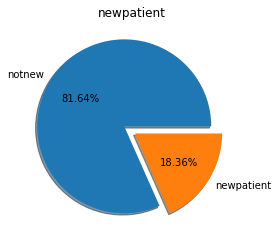

In [30]:
newpatient['newpatient'].value_counts()

label=['notnew','newpatient']
value_label=newpatient['newpatient'].value_counts()
explode=[0.1,0.05]
fig,ax=plt.subplots()
ax.pie(value_label,explode=explode,labels=label,autopct='%1.2f%%',shadow=True)
ax.set(title='newpatient');

In [31]:
newpatient['newpatient'].value_counts()

N    145837
Y     32790
Name: newpatient, dtype: int64

In [32]:
file_name = 'newpatient_gd.xlsx'
newpatient.to_excel(file_name)